## Importing required packages and initializing Spark session

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Reading data

In [5]:
df = spark.read.format("csv").option("header", "true").load("./Uber-dataset/uber-raw-data-apr14.csv")

In [6]:
df.show(5)

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|4/1/2014 0:11:00| 40.769|-73.9549|B02512|
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|
+----------------+-------+--------+------+
only showing top 5 rows



## Extracting the columns 'Lat' and 'Lon' which further undergo clustering

In [7]:
clus_df = df.selectExpr("cast(Lat as float) Lat","cast(Lon as float) Lon")
clus_df.show(5)

+-------+--------+
|    Lat|     Lon|
+-------+--------+
| 40.769|-73.9549|
|40.7267|-74.0345|
|40.7316|-73.9873|
|40.7588|-73.9776|
|40.7594|-73.9722|
+-------+--------+
only showing top 5 rows



## Combining the 'Lat' and 'Lon' columns to form 'features' column

In [8]:
vecAssembler = VectorAssembler(inputCols=["Lat", "Lon"], outputCol="features")
clus_df = vecAssembler.transform(clus_df)

In [9]:
clus_df.show(1)

+------+--------+--------------------+
|   Lat|     Lon|            features|
+------+--------+--------------------+
|40.769|-73.9549|[40.7690010070800...|
+------+--------+--------------------+
only showing top 1 row



## Finding the optimal value for 'k' using 'elbow method'

In [10]:
cost = [0]

for k in range(2,11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(clus_df)
    cost.append(model.computeCost(clus_df))

In [11]:
cost

[0,
 1355.9504299227885,
 1023.1596339309003,
 910.2501394254429,
 697.4620291501898,
 639.4252562144128,
 409.00272506492246,
 531.8033392656347,
 391.2912305837879,
 378.21660283458726]

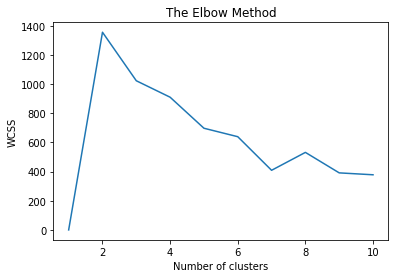

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1,11), cost)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## From the above plot of elbow method, it is chosen that k=6
## Training the KMeans model over the dataset

In [13]:
kmeans = KMeans(k=6, seed=1)
kmeans_model = kmeans.fit(clus_df.select("features"))

In [14]:
clus_df = kmeans_model.transform(clus_df)
clus_df.show()

+-------+--------+--------------------+----------+
|    Lat|     Lon|            features|prediction|
+-------+--------+--------------------+----------+
| 40.769|-73.9549|[40.7690010070800...|         3|
|40.7267|-74.0345|[40.7266998291015...|         0|
|40.7316|-73.9873|[40.7316017150878...|         0|
|40.7588|-73.9776|[40.7588005065918...|         4|
|40.7594|-73.9722|[40.7593994140625...|         4|
|40.7383|-74.0403|[40.7383003234863...|         0|
|40.7223|-73.9887|[40.7223014831543...|         0|
| 40.762| -73.979|[40.7620010375976...|         4|
|40.7524| -73.996|[40.7523994445800...|         4|
|40.7575|-73.9846|[40.7574996948242...|         4|
|40.7256|-73.9869|[40.7256011962890...|         0|
|40.7591|-73.9684|[40.7591018676757...|         4|
|40.7271|-73.9803|[40.7271003723144...|         4|
|40.6463|-73.7896|[40.6463012695312...|         1|
|40.7564|-73.9167|[40.7564010620117...|         3|
|40.7666|-73.9531|[40.7666015625,-7...|         3|
| 40.758|-73.9761|[40.757999420

## Getting the centroid of each cluster and plotting them 

In [15]:
clus_centers = kmeans_model.clusterCenters()
clus_centers

[array([ 40.72473483, -74.00730999]),
 array([ 40.65807628, -73.77421418]),
 array([ 40.79478525, -73.8597065 ]),
 array([ 40.78053098, -73.95947686]),
 array([ 40.75305274, -73.98313497]),
 array([ 40.68814104, -73.9637823 ])]

In [16]:
x_center = []
y_center = []
for center in clus_centers:
    x_center.append(center[0])
    y_center.append(center[1])

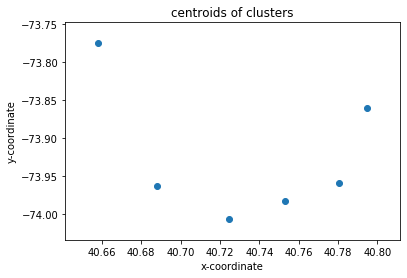

In [17]:
plt.scatter(x_center, y_center)
plt.title('centroids of clusters')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.show()

## Visualizing the centroids using a real world map as the datapoints represent different locations in New York city

In [18]:
import folium

In [19]:
clus_centers = pd.DataFrame(list(map(np.ravel, clus_centers)))
clus_centers

,0,1
0,40.724735,-74.007310
1,40.658076,-73.774214
2,40.794785,-73.859706
3,40.780531,-73.959477
4,40.753053,-73.983135
5,40.688141,-73.963782


In [20]:
centroids = clus_centers.values.tolist()

map = folium.Map(location=[40.688142,-73.963783], zoom_start=25)
for point in range(0, len(centroids)):
    folium.Marker(centroids[point], popup=centroids[point]).add_to(map)
map

## Getting the count of number of datapoints in each cluster and visualizing it

In [21]:
predictions = np.array(clus_df.select("prediction").collect()).reshape(-1)
count = np.zeros(6)
for point in predictions:
    if(point==0):
        count[0]+=1
    elif(point==1):
        count[1]+=1;
    elif(point==2):
        count[2]+=1
    elif(point==3):
        count[3]+=1
    elif(point==4):
        count[4]+=1
    else:
        count[5]+=1

In [22]:
count

array([181982.,  14209.,  16931.,  77250., 217565.,  56579.])

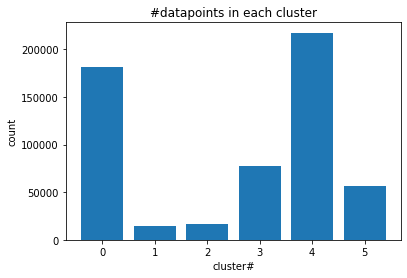

In [23]:
plt.bar(np.arange(len(count)), count)
plt.xlabel("cluster#")
plt.ylabel("count")
plt.title("#datapoints in each cluster")
plt.show()